# Precipitation and temperature downscaling using GANs

In [1]:
# Common imports
import os
import yaml
import math
import numpy as np
import xarray as xr
import dask
from time import time

# Import torch
import torch
from torch.utils.data import Dataset, DataLoader

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

# Utils
from utils.data_loader import *
from utils.utils_plot import *
from utils.utils_gans import *

# Try dask.distributed and see if the performance improves...
from dask.distributed import Client
c = Client(n_workers=os.cpu_count()-2, threads_per_worker=1)


In [2]:
print("Cuda Avaliable :", torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Cuda Avaliable : True
cuda


In [3]:
# Define paths and constant
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Paths
PATH_DEM = config['PATH_DEM']
PATH_ERA5_025 = config['PATH_ERA5_025']  # Original ERA5 0.25°
PATH_ERA5_100 = config['PATH_ERA5_100']  # ERA5 1°
PATH_MCH = config['PATH_MeteoSwiss']  # Note that Meteoswiss has a different coordinate system, but it doesn't matter here, as we only care about tensors

# Data options
DATE_START = '1999-01-01'  # '1979-01-01'
DATE_END = '2021-12-31'
YY_TRAIN = [1999, 2015]  # [1979, 2015]
YY_TEST = [2016, 2021]
LEVELS = [850,1000] #[300, 500, 700, 850, 1000]  # Available with CORDEX-CMIP6
RESOL_LOW = 0.25  # degrees
INPUT_VARS = ['tp', 't']
INPUT_PATHS = [PATH_ERA5_025 + '/precipitation', PATH_ERA5_025 + '/temperature']
DUMP_DATA_TO_PICKLE = True

# Crop on a smaller region
DO_CROP = True
# I reduce the area of crop now, to avoid NA
CROP_X = [2700000, 2760000]  # with NAN: [2720000, 2770000]
CROP_Y = [1190000, 1260000]  # with NAN: [1290000, 1320000]

# Hyperparameters
BATCH_SIZE = 32

# Display options
PLOT_DATA_FULL_EXTENT = False
PLOT_DATA_CROPPED = True

## Target variables

In [4]:
# Load target data
target = load_target_data(DATE_START, DATE_END, PATH_MCH)

Extracting target data...
Extracting data for the period 1999-01-01 - 2021-12-31
Extracting data for the period 1999-01-01 - 2021-12-31
Extracting data for the period 1999-01-01 - 2021-12-31
Extracting data for the period 1999-01-01 - 2021-12-31


In [6]:
# Extract the axes of the final target domain based on temperature 
x_axis = target.TabsD.x
y_axis = target.TabsD.y

In [7]:
if PLOT_DATA_FULL_EXTENT:
    fig, axs = plt.subplots(1, 4, figsize=(18,4))
    plot_map(axs[0], target.RhiresD.mean(dim='time').to_numpy().squeeze(), title="Daily precipitation", cmap=mpl.cm.YlGnBu)
    plot_map(axs[1], target.TabsD.mean(dim='time').to_numpy().squeeze(), title="Daily Temperature", cmap=mpl.cm.RdBu_r)
    plot_map(axs[2], target.TmaxD.mean(dim='time').to_numpy().squeeze(), title="Daily Maximum temperature", cmap=mpl.cm.RdBu_r)
    plot_map(axs[3], target.TminD.mean(dim='time').to_numpy().squeeze(), title="Daily Minimum temperature", cmap=mpl.cm.RdBu_r)

## Input variables

In [8]:
input_data = load_input_data(DATE_START, DATE_END, PATH_DEM, INPUT_VARS, INPUT_PATHS, 
                             LEVELS, RESOL_LOW, x_axis, y_axis)

Input data loaded from pickle.


In [9]:
if PLOT_DATA_FULL_EXTENT:
    fig, axs = plt.subplots(1, 4, figsize=(18,4))
    plot_map(axs[0], input_data.topo.to_numpy().squeeze(), title="Topography", cmap=mpl.cm.terrain)
    plot_map(axs[1], input_data.tp.mean(dim='time').to_numpy().squeeze(), title="Input precipitation", cmap=mpl.cm.YlGnBu)
    plot_map(axs[2], input_data.t.sel(level=850).mean(dim='time').to_numpy().squeeze(), title="Input temperature at 850hPa", cmap=mpl.cm.RdBu_r)
    plot_map(axs[3], input_data.t.sel(level=1000).mean(dim='time').to_numpy().squeeze(), title="Input temperature at 1000hPa", cmap=mpl.cm.RdBu_r)

## Crop domain

In [10]:
if DO_CROP:
    input_data = input_data.sel(x=slice(min(CROP_X), max(CROP_X)), y=slice(max(CROP_Y), min(CROP_Y)))
    target = target.sel(x=slice(min(CROP_X), max(CROP_X)), y=slice(max(CROP_Y), min(CROP_Y)))

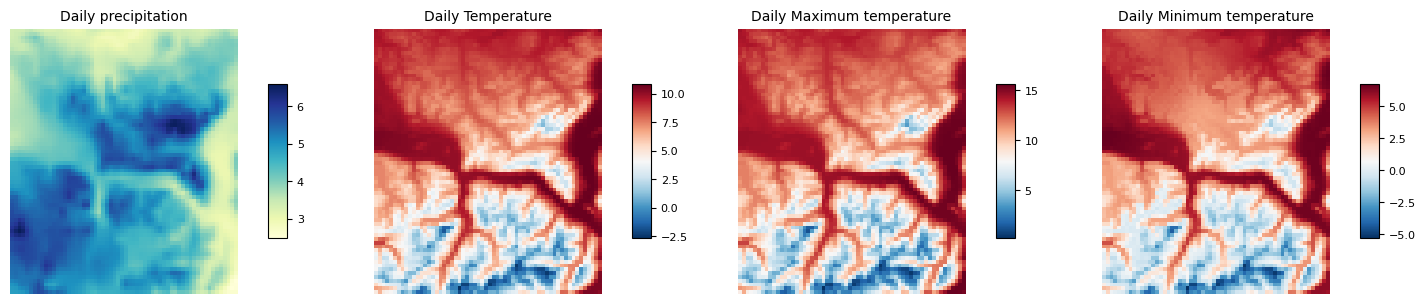

In [11]:
if DO_CROP and PLOT_DATA_CROPPED:
    fig, axs = plt.subplots(1, 4, figsize=(18,4))
    plot_map(axs[0], target.RhiresD.mean(dim='time').to_numpy().squeeze(), title="Daily precipitation", cmap=mpl.cm.YlGnBu)
    plot_map(axs[1], target.TabsD.mean(dim='time').to_numpy().squeeze(), title="Daily Temperature", cmap=mpl.cm.RdBu_r)
    plot_map(axs[2], target.TmaxD.mean(dim='time').to_numpy().squeeze(), title="Daily Maximum temperature", cmap=mpl.cm.RdBu_r)
    plot_map(axs[3], target.TminD.mean(dim='time').to_numpy().squeeze(), title="Daily Minimum temperature", cmap=mpl.cm.RdBu_r)

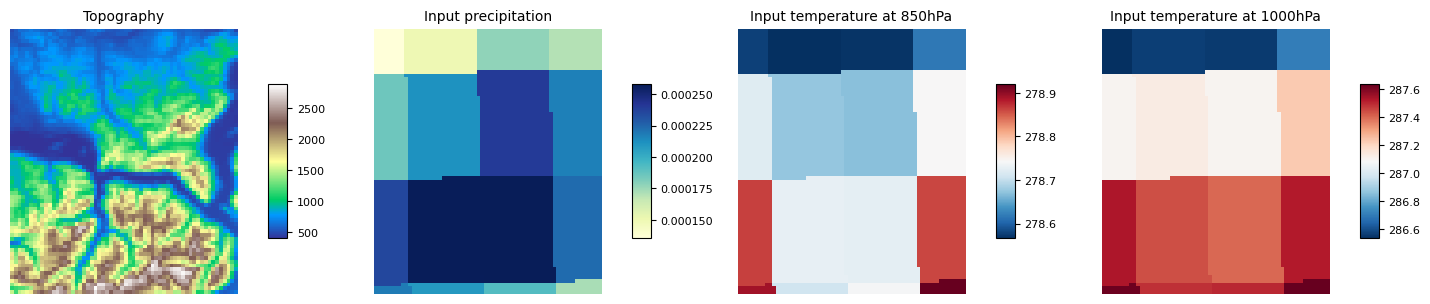

In [14]:
if DO_CROP and PLOT_DATA_CROPPED:
    fig, axs = plt.subplots(1, 4, figsize=(18,4))
    plot_map(axs[0], input_data.topo.to_numpy().squeeze(), title="Topography", cmap=mpl.cm.terrain)
    plot_map(axs[1], input_data.tp.mean(dim='time').to_numpy().squeeze(), title="Input precipitation", cmap=mpl.cm.YlGnBu)
    plot_map(axs[2], input_data.t.sel(level=850).mean(dim='time').to_numpy().squeeze(), title="Input temperature at 850hPa", cmap=mpl.cm.RdBu_r)
    plot_map(axs[3], input_data.t.sel(level=1000).mean(dim='time').to_numpy().squeeze(), title="Input temperature at 1000hPa", cmap=mpl.cm.RdBu_r)

## Split sample and data generator

In [ ]:
# Split the data
x_train = input_data.sel(time=slice('1999', '2011')) 
x_valid = input_data.sel(time=slice('2012', '2015')) 
x_test = input_data.sel(time=slice('2016', '2021'))

y_train = target.sel(time=slice('1999', '2011'))
y_valid = target.sel(time=slice('2012', '2005'))
y_test = target.sel(time=slice('2006', '2011'))

In [ ]:
dic = {'topo' : None,
       'tp': None,
       't': LEVELS}

In [ ]:
output_vars = ['RhiresD', 'TabsD', 'TmaxD', 'TminD']

In [ ]:
def log_trans(x, e):
    return np.log(x + e) - np.log(e)

def log_retrans(x, e):
    return np.exp(x + np.log(e)) - e

In [ ]:
# Create data generator in pytorch # Adapted from the keras class
class DataGenerator(Dataset):
    def __init__(self, ds, label, var_dict, output_vars, batch_size=32, load=True, mean=None, std=None, lead_time=None, tp_log=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all input variables
            label: output
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
            tp_log: Log transformation
        """
        self.ds = ds
        self.dy = label
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.lead_time = lead_time
        self.output_vars = output_vars
                
        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        
        #for var, levels in var_dict.items():
        #    if levels is None:
        #        data.append(ds[var].expand_dims({'level': generic_level}, 1)) 
        #    else:
        #        data.append(ds[var].sel(level=levels))

        for var, levels in var_dict.items():
            #print(var)
            if var == 'topo':
                data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
            else:
                
                if var == 'tp':
                    if tp_log:
                        da = log_trans(ds[var], tp_log)
                        data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    else:
                        data.append(ds[var].expand_dims({'level': generic_level}, 1))
                if 'level' in ds[var].coords:
                    data.append(ds[var].sel(level=LEVELS))
                else:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                   
       
        # Change level position 
        
        self.data = xr.concat(data, 'level').transpose('time', 'y', 'x', 'level')
        self.mean = self.data.mean(('time', 'y', 'x')).compute() if mean is None else mean
        self.std  = self.data.mean(('time', 'y', 'x')).compute() if std is None else std
        
        
        # Normalize 
        self.data = (self.data - self.mean) / self.std
        
        if self.lead_time is None: 
            self.n_samples = self.data.shape[0]
        else:
            self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
            self.init_time = self.data.isel(time=slice(None, -lead_time)).time
            self.valid_time = self.data.isel(time=slice(lead_time, None)).time
            
        self.idxs = np.arange(self.n_samples)
        

        # prepare the target
        # Prepare the target
      
        self.dy = [self.dy[var] for var in self.output_vars]
        # Concatenate the DataArray objects along a new dimension
        self.dy = xr.concat(self.dy, dim='level').transpose('time', 'y', 'x', 'level')

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

        
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        idxs = self.idxs[idx]
        
        X = (torch.Tensor(self.data.isel(time=idxs).values))
        
        if self.lead_time is None:
             y = (torch.Tensor(self.dy.isel(time=idxs).values))
        else:
             y = (torch.Tensor(self.dy.isel(time=idxs + self.lead_time).values))
                
        # In PyTorch we must transpose (C,H,W,B)
        X = torch.Tensor(X).permute(2, 0, 1)
        
        if y.ndim > 2:
            y = torch.Tensor(y).permute(2, 0, 1)
        else:
            # expand dimensions
            y = torch.unsqueeze(y, dim=0)

            
        return X, y    


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in divide")

In [ ]:
training_set = DataGenerator(x_train, y_train, dic, output_vars, batch_size=BATCH_SIZE, lead_time = None)
loader_train = torch.utils.data.DataLoader(training_set, batch_size=32)

In [ ]:
# Validation
valid_set = DataGenerator(x_valid, y_valid, dic, output_vars, batch_size=BATCH_SIZE, mean=training_set.mean, std=training_set.std, lead_time = None)
loader_val = torch.utils.data.DataLoader(valid_set, batch_size=32)
# Test
test_set = DataGenerator(x_test, y_test, dic, output_vars, batch_size=BATCH_SIZE, mean=training_set.mean, std=training_set.std, lead_time = None)
loader_test = torch.utils.data.DataLoader(test_set, batch_size=32)

In [ ]:
# Check to make sure the range on the input and output images is correct, and they're the correct shape
testx, testy = training_set.__getitem__(3)
print("x shape: ", testx.shape)
print("y shape: ", testy.shape)
print("x min: ", torch.min(testx))
print("x max: ", torch.max(testx))
print("y min: ", torch.min(testy))
print("y max: ",torch.max(testy))

In [ ]:
data = next(iter(loader_train))
x, y = data
print('Shape of x:', x.shape)
print('Shape of y:', y.shape)

In [ ]:
# Plot input
# Plotting the mean of the predictors
n_figs = len(x[0,:,0,0])
ncols = 3
nrows = -(-n_figs // ncols)
fig, axes = plt.subplots(figsize=(24, 3.3*nrows), ncols=ncols, nrows=nrows)
for i in range(n_figs):
    i_row = i // ncols
    i_col = i % ncols
    ax = axes[i_row, i_col]
    vals = torch.mean(x[:,i,:,:],axis=0)
    plot_map(ax, vals, title=f"Average of feature {i+1}")


In [ ]:
# Defining the G and D
# Adapted from https://github.com/mantariksh/231n_downscaling/blob/master/SRGAN.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T


In [ ]:
# Convenience 
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Discriminator(nn.Module):
    def __init__(self, num_channels, H, W):
        super().__init__()
        
        self.layers = nn.Sequential( 
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            Flatten(),  
            nn.Linear(512 * int(np.ceil(H/16)) * int(np.ceil(W/16)), 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        return self.layers(x)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(num_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(num_channels)
        )

    def forward(self, x):
        return x + self.layers(x)


        
class UpscaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.layers(x)

class Generator(nn.Module):
    def __init__(self, num_channels, input_size, output_channels =4, num_res_blocks=16, scale_factor=1):
        super().__init__()
        
        self.num_res_blocks = num_res_blocks
        self.input_size = input_size
        self.output = output_channels
        self.initial_conv = nn.Sequential(
            nn.ReflectionPad2d(4),
            nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=0),
            nn.PReLU()
        )
        
        self.resBlocks = nn.ModuleList([ResidualBlock(64) for i in range(self.num_res_blocks)])

        self.post_resid_conv = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64)
        )

        self.upscale_blocks = nn.ModuleList()
        for _ in range(int(math.log(scale_factor, 2))):
            self.upscale_blocks.append(UpscaleBlock(64, 64 * 4, scale_factor=2))

        self.conv_prelu = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.PReLU()
        )
    
        self.final_conv = nn.Sequential(
            nn.ReflectionPad2d(4),
            nn.Conv2d(64, self.output, 9, stride=1, padding=0)
        )

    def forward(self, x):
        initial_conv_out = self.initial_conv(x)
                
        res_block_out = self.resBlocks[0](initial_conv_out)
        for i in range(1, self.num_res_blocks):
            res_block_out = self.resBlocks[i](res_block_out)

        post_resid_conv_out = self.post_resid_conv(res_block_out) + initial_conv_out

        upscale_out = post_resid_conv_out
        for block in self.upscale_blocks:
            upscale_out = block(upscale_out)

        conv_prelu_out = self.conv_prelu(upscale_out)
        final_out = self.final_conv(conv_prelu_out)
        # To get the final desired shape
        print(final_out.shape)
        final_out = F.interpolate(final_out, size=self.input_size, mode='bicubic', align_corners=True)

        return final_out


In [ ]:
### Test the Generator

In [ ]:
NUM_CHANNELS_IN = 5
dtype = torch.float32 
input_size=y.shape[1:]


In [ ]:
print(input_size)

### Check the generator

In [ ]:
torch.cuda.empty_cache()

In [ ]:
x,y = (training_set.__getitem__(3))

In [ ]:
x = x.unsqueeze(0)
print(x.shape)

In [ ]:
model = Generator(NUM_CHANNELS_IN,input_size)
model = model.to(device=device)
x = x.to(device=device)
    

In [ ]:
x.shape

In [ ]:
output = model(x)

In [ ]:
output.shape

In [ ]:
plt.subplot(121)
plt.imshow(x.cpu().detach().numpy()[0, 1, :, :])
plt.title("Input low-res Precip")
plt.subplot(122)
plt.imshow(output.cpu().detach().numpy()[0, 0, :, :])
plt.title("Output Precip")
plt.figure()

In [ ]:
plt.subplot(121) #??
plt.imshow(x.cpu().detach().numpy()[0, 2, :, :])
plt.title("Input low-res Temp")
plt.subplot(122)
plt.imshow(output.cpu().detach().numpy()[0, 1, :, :])
plt.title("Output Temp")
plt.figure()

### Check the discriminator

In [ ]:
x,y = (training_set.__getitem__(3))

In [ ]:
print(x.shape)

In [ ]:
#y = y.unsqueeze(0)
print(y.shape)

In [ ]:
h, w = y.shape[1:]

In [ ]:
#### Test the discriminator
def test_Discriminator():
    x,y = (training_set.__getitem__(3))
    y = y.unsqueeze(0)
    print("y: ", y.shape)
    model = Discriminator(num_channels=1, H=h,W=w)
    output = model(y)
    print(output.size())
    print(output)
#test_Discriminator()


def test_withnan_Discriminator():
    x, y = training_set.__getitem__(3)
    y = y.unsqueeze(0)
    print("y shape:", y.shape)

    # Replace NaN values with a valid value
    y = torch.where(torch.isnan(y), torch.zeros_like(y), y)

    model = Discriminator(num_channels=1, H=h, W=w)
    output = model(y)
    print("Output size:", output.size())
    print(output)

test_withnan_Discriminator()

In [ ]:
def generator_withNan_loss(gen_img, true_img, logits_fake, weight_param=1e-3):
    """
    Computes the generator loss described above.

    Inputs:
    - gen_img: (PyTorch tensor) shape N, C image generated by the Generator, so that we can calculate MSE
    - true_img: (PyTorch tensor) the true, high res image, so that we can calculate the MSE
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - weight_param: how much to weight the adversarial loss by when summing the losses. Default in Ledig paper is 1e-3
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    #
    if torch.isnan(gen_img).any() or torch.isnan(true_img).any() or torch.isnan(logits_fake).any():
        # Handle NaN values here
        # Replace NaN values in gen_img and true_img with zeros
        gen_img = torch.where(torch.isnan(gen_img), torch.zeros_like(gen_img), gen_img)
        true_img = torch.where(torch.isnan(true_img), torch.zeros_like(true_img), true_img)

    
    # Content loss - MSE loss
    content_loss_func = nn.MSELoss()
    content_loss = content_loss_func(gen_img, true_img)
        
    N = logits_fake.shape[0]
    desired_labels = torch.ones(N, 1).to(device=device, dtype=dtype)
    BCE_Loss = nn.BCELoss()
    adversarial_loss = BCE_Loss(logits_fake, desired_labels)
    
    total_loss = content_loss + weight_param * adversarial_loss
    
    return total_loss, content_loss, adversarial_loss


In [ ]:
def generator_withNaN_loss(gen_img, true_img, logits_fake, weight_param=1e-3):
    """
    Computes the generator loss described above.

    Inputs:
    - gen_img: (PyTorch tensor) shape N, C image generated by the Generator, so that we can calculate MSE
    - true_img: (PyTorch tensor) the true, high res image, so that we can calculate the MSE
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - weight_param: how much to weight the adversarial loss by when summing the losses. Default in Ledig paper is 1e-3
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    # Handle NaN values in gen_img and true_img
    gen_img = torch.where(torch.isnan(gen_img), torch.zeros_like(gen_img), gen_img)
    true_img = torch.where(torch.isnan(true_img), torch.zeros_like(true_img), true_img)
    
    # Content loss - MSE loss
    content_loss_func = nn.MSELoss()
    content_loss = content_loss_func(gen_img, true_img)
        
    N = logits_fake.shape[0]
    desired_labels = torch.ones(N, 1).to(device=device, dtype=dtype)
    BCE_Loss = nn.BCELoss()
    adversarial_loss = BCE_Loss(logits_fake, desired_labels)
    
    total_loss = content_loss + weight_param * adversarial_loss
    
    return total_loss, content_loss, adversarial_loss


In [ ]:
def discriminator_with_Nan_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data (real numbers). 
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data (real numbers).
    
    Returns:
    - loss: PyTorch Tensor containing the loss for the discriminator.
    """
    # Handle NaN values
    if torch.isnan(logits_real).any() or torch.isnan(logits_fake).any():
        # Replace NaN values with zeros
        logits_real = torch.where(torch.isnan(logits_real), torch.zeros_like(logits_real), logits_real)
        logits_fake = torch.where(torch.isnan(logits_fake), torch.zeros_like(logits_fake), logits_fake)

    N = logits_real.shape[0]
    real_labels = torch.ones(N, 1).to(device=logits_real.device, dtype=logits_real.dtype)
    fake_labels = torch.zeros(N, 1).to(device=logits_fake.device, dtype=logits_fake.dtype)
    
    BCE_Loss = nn.BCELoss()
    L1 = BCE_Loss(logits_real, real_labels)
    L2 = BCE_Loss(logits_fake, fake_labels)
    
    loss = L1 + L2
    return loss, L1, L2




In [ ]:
import torch
import numpy as np

def check_generator_with_nan_accuracy(loader, model):
    model.eval()
    count, rmse_precip_ypred, rmse_precip_x = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            model = model.to(device=device)
            y = y.to(device=device, dtype=dtype)
            
            x_np = x.numpy()
            x_min = np.amin(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            x_max = np.amax(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            is_nan = np.int((x_min == x_max).any())
            eps = 1e-9
            x_norm_np = (x_np - x_min) / ((x_max - x_min + is_nan*eps) / 2) - 1
            x_norm_np[np.isnan(x_norm_np)] = 0  # Replace NaN values with zeros
            
            x_norm = torch.from_numpy(x_norm_np)
            x_norm = x_norm.to(device=device, dtype=dtype)
            x = x.to(device=device, dtype=dtype)
            
            y_predicted = model(x)
            y_predicted[np.isnan(y_predicted)] = 0  # Replace NaN values with zeros
            
            rmse_precip_ypred += torch.sqrt(torch.mean((y_predicted[:,0,:,:]-y[:,0,:,:]).pow(2)))
            rmse_precip_x += torch.sqrt(torch.mean((x_norm[:,0,:,:]-y[:,0,:,:]).pow(2)))
            count += 1
            
        rmse_precip_ypred /= count
        rmse_precip_x /= count
        print('RMSEs: \tInput precip: %.3f\n\tOutput precip: %.3f\n\t' % 
              (rmse_precip_x, rmse_precip_ypred))
        
        
def check_discriminator_with_nan_accuracy(loader, D, G):
    D = D.to(device=device)
    G = G.to(device=device)
    D.eval()
    G.eval()
    
    count, avg_true_pred, avg_fake_pred = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            
            true_pred = D(y)
            true_pred[np.isnan(true_pred)] = 0  # Replace NaN values with zeros
            avg_true_pred += true_pred.sum()
            count += len(true_pred)
            
            fake_imgs = G(x)
            fake_pred = D(fake_imgs)
            fake_pred[np.isnan(fake_pred)] = 0  # Replace NaN values with zeros
            avg_fake_pred += fake_pred.sum()
            
        avg_true_pred /= count
        avg_fake_pred /= count
        print("Average prediction score on real data: %f" % (avg_true_pred))
        print("Average prediction score on fake data: %f" % (avg_fake_pred))


In [ ]:

# Helper functions for plotting
def plot_epoch(x, y_pred, y):
    figsize = (9,4)
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plt.imshow(x[0,0,:,:].cpu().detach().numpy())
    plt.title("Input Precip")
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0,0,:,:].cpu().detach().numpy())
    plt.title("Output Precip")
    plt.subplot(1,3,3)
    plt.imshow(y[0,0,:,:].cpu().detach().numpy())
    plt.title("True Precip")
    
    
def plot_loss(G_content, G_advers, D_real_L, D_fake_L, weight_param):
    
    D_count = np.count_nonzero(D_real_L)
    G_count = np.count_nonzero(G_content)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(range(G_count), G_content[range(G_count)])
    plt.plot(range(G_count), G_advers[range(G_count)])
    plt.plot(range(G_count), G_content[range(G_count)] + weight_param*G_advers[range(G_count)])
    plt.legend(("Content", "Adversarial", "Total"))
    plt.title("Generator loss")
    plt.xlabel("Iteration")
    
    plt.subplot(1,2,2)
    plt.plot(range(D_count), D_real_L[range(D_count)])
    plt.plot(range(D_count), D_fake_L[range(D_count)])
    plt.plot(range(D_count), D_real_L[range(D_count)] + D_fake_L[range(D_count)])
    plt.legend(("Real Pic", "Fake Pic", "Total"))
    plt.title("Discriminator loss")
    plt.xlabel("Iteration")
    plt.show()

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
D = Discriminator(num_channels=1, H=h,W=w) 
G = Generator(NUM_CHANNELS_IN, input_size)

lr = 0.0002
# No checkpoints....
# Define optimizer for discriminator
D_solver = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# Define optimizer for generator
G_solver = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
num_epochs=2
G_iters=1
dtype = torch.float32

In [ ]:
# Move the models to the correct device (GPU if GPU is available)
D = D.to(device=device)
G = G.to(device=device)
    
# Put models in training mode
D.train()
G.train()
    
print("Expected num iters: ", len(loader_train)*num_epochs)
G_content = np.zeros(len(loader_train)*num_epochs*G_iters+1)
G_advers = np.zeros(len(loader_train)*num_epochs*G_iters+1)
D_real_L = np.zeros(len(loader_train)*num_epochs+1)
D_fake_L = np.zeros(len(loader_train)*num_epochs+1)

In [ ]:
#high_res_imgs = y.to(device=device, dtype=dtype)
#logits_real = D(high_res_imgs)

#x.requires_grad_()
#low_res_imgs = x.to(device=device, dtype=dtype)
#fake_images = G(low_res_imgs)
#logits_fake = D(fake_images)

In [ ]:
#fake_images.shape

In [ ]:
#logits_fake.shape

In [ ]:
#d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_loss(logits_real, logits_fake)

In [ ]:
#discriminator_loss(logits_real, logits_fake)

In [ ]:
###################TEST
#iter_count = 0
#G_iter_count = 0
#show_every=40
#tic = time()
#for epoch in range(num_epochs):
#    for x,y in loader_train:
#        high_res_imgs = y.to(device=device, dtype=dtype)
#        logits_real = D(high_res_imgs)

#       x.requires_grad_()
#        low_res_imgs = x.to(device=device, dtype=dtype)
#        fake_images = G(low_res_imgs)
#        logits_fake = D(fake_images)

In [ ]:
#d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_with_Nan_loss(logits_real, logits_fake)

In [ ]:
iter_count = 0
G_iter_count = 0
show_every=40
tic = time()
for epoch in range(num_epochs):
    for x,y in loader_train:
        high_res_imgs = y.to(device=device, dtype=dtype)
        logits_real = D(high_res_imgs)

        x.requires_grad_()
        low_res_imgs = x.to(device=device, dtype=dtype)
        fake_images = G(low_res_imgs)
        logits_fake = D(fake_images)
    
        # Update for the discriminator
        #d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_with_Nan_loss(logits_real, logits_fake)
        d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_loss(logits_real, logits_fake)
        #print('d_total_error:', d_total_error)
        #print('D_real_L[iter_count]:', D_real_L[iter_count])
        #print('D_fake_L[iter_count]:', D_fake_L[iter_count])
        D_solver.zero_grad()
        d_total_error.backward()
        D_solver.step()
        
        for i in range(G_iters):
                # Update for the generator
                fake_images = G(low_res_imgs)
                logits_fake = D(fake_images)
                gen_logits_fake = D(fake_images)
                weight_param = 1e-1 # Weighting put on adversarial loss
                g_error, G_content[G_iter_count], G_advers[G_iter_count] = generator_loss(fake_images, high_res_imgs, gen_logits_fake, weight_param=weight_param)
                #g_error, G_content[G_iter_count], G_advers[G_iter_count] = generator_withNan_loss(fake_images, high_res_imgs, gen_logits_fake, weight_param=weight_param)
                
                G_solver.zero_grad()
                g_error.backward()
                G_solver.step()
                G_iter_count += 1
                
        if (iter_count % show_every == 0):
                toc = time()
                print('Epoch: {}, Iter: {}, D: {:.4}, G: {:.4}, Time since last print (min): {:.4}'.format(epoch,iter_count,d_total_error.item(),g_error.item(), (toc-tic)/60 ))
                tic = time()
                plot_epoch(x, fake_images, y)
                plot_loss(G_content, G_advers, D_real_L, D_fake_L, weight_param)
                print()
        iter_count += 1
        
        D = D.to(device=device)
        G = G.to(device=device)
        # Put models in training mode
        D.train()
        G.train()